In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import SensitivityAtSpecificity

In [2]:
datagen = ImageDataGenerator(rescale=1./255)
image_dim = 96
batch_size = 32

In [3]:
train_generator = datagen.flow_from_directory(
        './base_dir/train_dir/',
        target_size=(image_dim, image_dim),
        batch_size=batch_size,
        class_mode='categorical')

Found 198022 images belonging to 2 classes.


In [4]:
val_generator = datagen.flow_from_directory(
        './base_dir/val_dir/',
        target_size=(image_dim, image_dim),
        batch_size=batch_size,
        class_mode='categorical')

Found 22003 images belonging to 2 classes.


In [5]:
# Split Data(X) and target(y) from train_generator
x_train, y_train = train_generator.next()

In [6]:
# Extract x_val from test_generator to use for predicting
x, y = zip(*(val_generator[i] for i in range(len(val_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)

In [7]:
epochs = 10
input_shape = x_train.shape[1:]

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        1

In [8]:
# Fit the model using epochs=10
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, shuffle=True, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6189 steps, validate for 688 steps
Epoch 1/10
6189/6189 [==============================] - 436s 71ms/step - loss: 0.3994 - accuracy: 0.8235 - val_loss: 0.4678 - val_accuracy: 0.8076
Epoch 2/10
6189/6189 [==============================] - 439s 71ms/step - loss: 0.3218 - accuracy: 0.8649 - val_loss: 0.2800 - val_accuracy: 0.8879
Epoch 3/10
6189/6189 [==============================] - 392s 63ms/step - loss: 0.2967 - accuracy: 0.8775 - val_loss: 0.2840 - val_accuracy: 0.8824
Epoch 4/10
6189/6189 [==============================] - 403s 65ms/step - loss: 0.2803 - accuracy: 0.8852 - val_loss: 0.2832 - val_accuracy: 0.8856
Epoch 5/10
6189/6189 [==============================] - 379s 61ms/step - loss: 0.2695 - accuracy: 0.8910 - val_loss: 0.3327 - val_accuracy: 0.8687
Epoch 6/10
6189/6189 [==============================] - 378s 61ms/step - loss: 0.2630 - accuracy: 0.8947 - val_loss: 0.2400 - val_accuracy: 0.9059
Epoch 7/10
6189/6189 [=

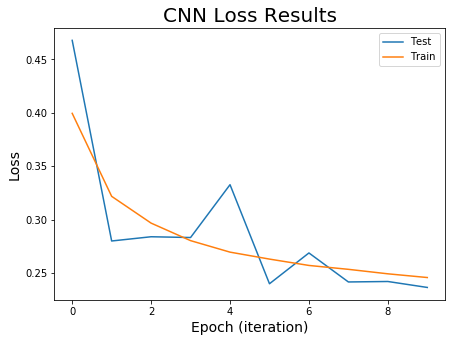

In [9]:
# plot of loss over 10 epochs
plt.figure(figsize = (7,5))
plt.title('CNN Loss Results', size=20)

plt.plot(history.history['val_loss'], label = 'Test')
plt.plot(history.history['loss'], label = 'Train')
plt.xlabel('Epoch (iteration)', size=14)
plt.ylabel('Loss', size=14)
plt.legend();

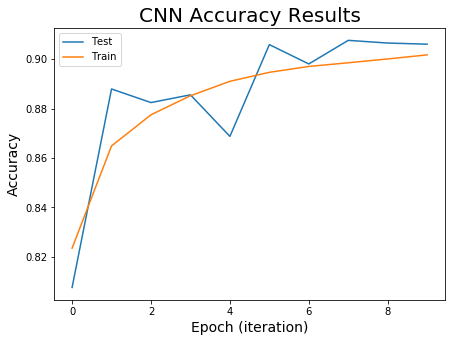

In [10]:
# plot of accuracy over 10 epochs
plt.figure(figsize = (7,5))
plt.title('CNN Accuracy Results', size=20)

plt.plot(history.history['val_accuracy'], label = 'Test')
plt.plot(history.history['accuracy'], label = 'Train')
plt.xlabel('Epoch (iteration)', size=14)
plt.ylabel('Accuracy', size=14)
plt.legend();

In [11]:
preds = model.predict(x_test)
pred_proba = [i[1] for i in preds]
true_val = [i[1] for i in y_test]
pred_df = pd.DataFrame({'true_values': true_val,
                        'pred_probs':pred_proba})

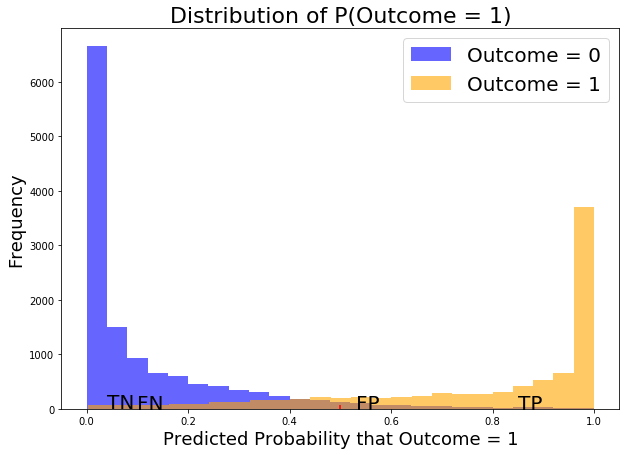

In [12]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 15),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.1, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.85, 1),
             s = 'TP',
             size = 20)

plt.annotate(xy = (0.53, 1),
             s = 'FP',
             size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

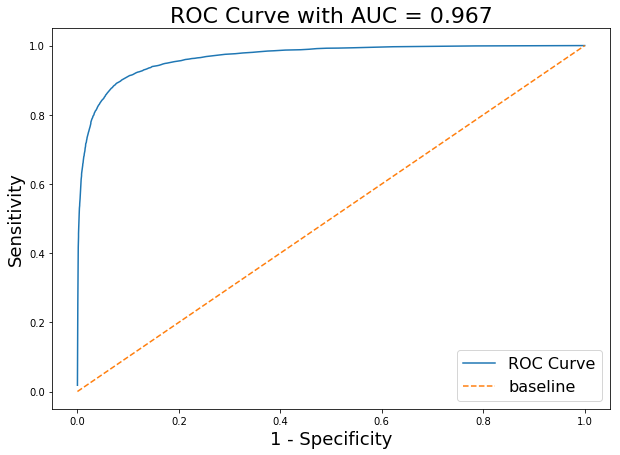

In [13]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

auc = round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)

# Label axes.
plt.title('ROC Curve with AUC = {}'.format(auc), fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [20]:
m = SensitivityAtSpecificity(0.9)
m.update_state(y_pred=preds, y_true = y_test)
m.result().numpy()

0.91260284

In [16]:
model.save('cnn_4')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cnn_4/assets
